<img width="800" src="./imlp1_images/pie.jpg" />

[Link](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#164fea706f63)

# Introduction to Machine Learning in Python 2 - Modeling and Evaluation

Steps in "almost every" modeling problem:

1. [Machine Learning](#learning)
2. [Evaluate & Tune](#evaluate)
3. [Explain](#explain)
4. [What Technology to Use](#tech)
4. [Sharing Knowledge in Team](#team) 
5. [Deploy & Monitor](#deploy)
6. [Keep Training & Production Environments Same](#production)

<a id="learning"></a>
## Machine Learning

![Machine Learning 2](./imlp2_images/machine_learning_2.png)

Supervised machine learning can be stated as follows. Find "the best" function $f$ that given set of $M$ descriptive features and $N$ instances of data $X_{11}, ..., X_{NM}$ returns values of target feature $y$.

$$ f(X_{i1}, ..., X_{iM}) = y_i \text{ for i} \in [1,N] $$

The model to find is the unknown function $f$.

### ML Pipeline

It is very useful to define complete machine learning pipeline in a declarative way using some higher-level stages (primitives) like transformers, estimators, and pipelines. Some advantages:

1. Any data transformation has to be "recorded" and replicated at all places where modeling happends (at least training and predicting).
2. Stages could be tested in isolation and reused among multiple ml pipelines.
3. Transformations applied are easy to read when described declaratively than programatically eg. using pandas df opps.

<img src="./imlp2_images/simple_pipeline.png" width="700" />

We split our dataset into train and test (holdout) datasets, we train on training data and evaluate model perfomance on unseen test dataset to simulate reality and to prevent overfitting of the model.

We replicate most of data transformations described in previous lecture using sklearn transformers.

In [63]:
# import some basic libraries to do analysis and ML
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Visualization details
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 6,6

Do basic preprocessing of available data. It makes sense to apply these transformations everywhere where we plan to use the model. 'No's and 'Yes's are better understood as zeros and ones.

In [64]:
# Read data from local .csv file and do basic preprocessing that makes sense to do everywhere
df = pd.read_csv('weatherAUS.csv')
df['RainToday'] = df['RainToday'].replace({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].replace({'Yes': 1, 'No': 0})
df['DateD'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['RainTodayD'] = df['RainToday'].map(lambda l: 1 if l == 'Yes' else 0)
df['Year'] = df['DateD'].dt.year
df['Month'] = df['DateD'].dt.month
df['YearMonth'] = df[['Year', 'Month']].apply(lambda r: f'{r[0]}-{r[1]:02d}', axis=1)

# Calculate rolling features that are hard to do in production but we check their importance here
def agg_days_since_rain(x):
    x = x[:-1]
    r = np.argmax(np.flip(x)) + 1 if x.any() else 20
    return r

def agg_rain_days(x):
    return np.sum(x[:-1])

def rolling_feature(d, by, on, val, window, name, agg_fce):
    cs = [by, on]
    r = d.sort_values(cs).groupby(by).rolling(window, on=on, min_periods=1)
    
    agg = r.apply(agg_fce, raw=True)
    agg[name] = agg[val] # agg has aggregated values in column val
    agg.drop([val, on], axis=1, inplace=True)
    agg.rename_axis(index=(by, 'Id'), inplace=True)
    agg.reset_index(inplace=True)
    return agg

# rolling_feature is custom rolling window function that takes different aggregation functions
dsrw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'DaysSinceRainWeek', agg_days_since_rain)
rdw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'RainDaysWeek', agg_rain_days)

# prepare original dataset to have the same index as rv
d = df.copy()
d.set_index(['Location'], append=True, inplace=True)
d.rename_axis(('Id', 'Location'), inplace=True)
d.reset_index(inplace=True)

# merge new features and drop technical columns
d = d.merge(dsrw, on=['Id', 'Location'])
d = d.merge(rdw, on=['Id', 'Location'])

d['NoRainWeek'] = d['DaysSinceRainWeek'].map(lambda l: 1 if l == 20 else 0)
d['DaysSinceRainWeek'] = d['DaysSinceRainWeek'].replace({20: 0})

df = d

We map input columns (features) from data frame to the input of model. All sklearn models require only numerical data as input, we impute missing values and add few basic transformations to test.

Imputing without any further transformations:

In [ ]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.pipeline import make_pipeline as mp

First, we have to impute using different strategies based on our EDA.

In [ ]:
features = []

# indicator for columns with many missing values
ff = ['Cloud9am', 'Cloud3pm', 'Humidity9am', 'Humidity3pm']
features += [('~indicator', SimpleImputer(strategy='median', add_indicator=True), ff)]

In [ ]:
# mean for features with no outliers
ff = ['Pressure9am', 'Pressure3pm', 'Temp3pm', 'Temp9am', 'MinTemp', 'MaxTemp']
features += [(f, SimpleImputer(strategy='mean'), [f]) for f in ff]

# median for features with outliers
ff = ['Evaporation', 'Sunshine']
features += [(f, SimpleImputer(strategy='median'), [f]) for f in ff]

In [114]:
# median for kind of categorical vars
ff = ['RainDaysWeek', 'DaysSinceRainWeek']
features += [(f, SimpleImputer(strategy='median'), [f]) for f in ff]

# 0 (zero) where it is sensible value
ff = ['RainToday', 'NoRainWeek']
features += [(f, SimpleImputer(strategy='constant', fill_value=0), [f]) for f in ff]

In [115]:
# we use log(x+1) to fix distributions
ff = ['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
features += [(f, mp(SimpleImputer(strategy='mean'), FunctionTransformer(np.log1p)), [f]) for f in ff]

In [116]:
# we use 2 features to create a new one
def gt0(a):
    a[a > 0] = 1
    a[a <= 0] = 0
    return a

ff = ['Pressure3pm', 'Pressure9am']
features += [('-PressureDiff', mp(SimpleImputer(strategy='median'), FunctionTransformer(np.diff)), ff)]
features += [('-PressureDrop', mp(SimpleImputer(strategy='median'), FunctionTransformer(np.diff), FunctionTransformer(gt0)), ff)]

In [117]:
# we generate one hot encodings for categorical features
ff = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
features += [(f, mp(SimpleImputer(strategy='most_frequent'), 
                    OneHotEncoder(drop='first', sparse=False)), [f]) for f in ff]

ff = ['Location', 'Month', 'YearMonth']
features += [(f, OneHotEncoder(drop='first', sparse=False, categories='auto'), [f]) for f in ff]

We randomly split dataset into training and testing datasets and separate column with target labels. We use training dataset to train the model and then we evaluate performance metrics of the model on testing (holdout, validation) dataset that model was not exposed to during training. This prevents overfitting and provides fairer evaluation of model performance closer to performance we can expect on production data.

Other schemas to prevent overfitting of the model like $k$-fold cross-validation are also possible and are discussed below.

In [118]:
from sklearn.model_selection import train_test_split

def split(df, label, test_size):
    train, test = train_test_split(df, test_size=.3)
    x_train = train.drop(label, axis=1)
    y_train = train[label]
    x_test = test.drop(label, axis=1)
    y_test = test[label]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split(df, 'RainTomorrow', test_size=.3)

### Decision Tree Model

Decision tree is one of the simplest models that we can use. In every node, it tries to find the feature and its threshold value that splits remaining dataset into classes in the best way until the remaining dataset contains only one class or its size is below some threshold.

Decision trees naturally handle missing data, work with categorical features, and do not require transformations of input features. Although working with missing data and categorical features are not supported in scikit-learn.

In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

We will train shallow decision tree and plot it to see how the model works.

In [120]:
m = Pipeline([('ct', ColumnTransformer(features)),
              ('clf', DecisionTreeClassifier(max_depth=2, criterion='entropy'))])

m.fit(x_train, y_train)
print('Classifition report on testing dataset\n')
print(classification_report(y_test, m.predict(x_test)))

Classifition report on testing dataset

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     33065
           1       0.79      0.28      0.41      9593

    accuracy                           0.82     42658
   macro avg       0.81      0.63      0.65     42658
weighted avg       0.82      0.82      0.79     42658



In [112]:
# Little magic to get to meaningful feature names after ColumnTransformer step.
# Mind that we combine multiple feature columns to engineer new feature or we use OHE

def get_feature_names(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        tn = transformer_in_columns[0]
        
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
            
        if isinstance(names,np.ndarray) or isinstance(names,list):
            if isinstance(transformer, OneHotEncoder):
                col_name += [f'{tn}_{n.replace("x0_", "")}' if 'x0_' in n else n for n in names]
            elif '~' in tn:
                col_name += names
                col_name += [f'{n}{tn}' for n in names]
            elif '-' in tn:
                col_name += [tn[1:]]
            else:
                col_name += names
        elif isinstance(names,str):
            col_name.append(names)
            
    return col_name
                             
ct = ColumnTransformer(features)
x_train_trans = ct.fit_transform(x_train, y_train)
x_test_trans = ct.transform(x_test)
fs = get_feature_names(ct)

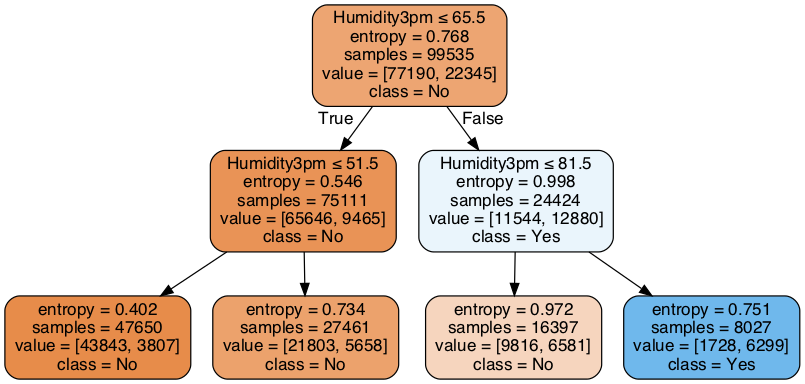

In [113]:
# plot decision tree rules

from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(m.named_steps['clf'], out_file=None, feature_names=fs, class_names=['No', 'Yes'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"10,4!"')
from IPython.display import Image
Image(graph.create_png())

In [24]:
dt_model = Pipeline([('ct', ColumnTransformer(features)),
                     ('clf', DecisionTreeClassifier(criterion='entropy'))])

dt_model.fit(x_train, y_train)
print('Classifition report on testing dataset\n')
print(classification_report(y_test, dt_model.predict(x_test)))

Classifition report on testing dataset

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     33011
           1       0.55      0.55      0.55      9647

    accuracy                           0.79     42658
   macro avg       0.71      0.71      0.71     42658
weighted avg       0.80      0.79      0.80     42658



### Sanity Check On Imputation

It is worth to check if we introduced some noice when doing imputation by testing the same algorithm on data where we drop all rows with any missing value. 

In [28]:
features_no_imp = []

ff = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Humidity9am', 'Humidity3pm', 'RainToday',
      'WindGustSpeed', 'Pressure9am', 'Pressure3pm', 'Temp3pm', 'Temp9am', 'MinTemp', 'MaxTemp',
      'RainDaysWeek', 'DaysSinceRainWeek', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'NoRainWeek']
features_no_imp += [(f, 'passthrough', [f]) for f in ff]

ff = ['Pressure3pm', 'Pressure9am']
features_no_imp += [('-PressureDiff', mp(SimpleImputer(strategy='median'), 
                                         FunctionTransformer(np.diff)), ff)]
features_no_imp += [('-PressureDrop', mp(SimpleImputer(strategy='median'), 
                                         FunctionTransformer(np.diff), 
                                         FunctionTransformer(gt0)), ff)]

ff = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location', 'Month', 'YearMonth']
features_no_imp += [(f, OneHotEncoder(drop='first', sparse=False, categories='auto'), [f]) for f in ff]

In [30]:
# train and evaluate decision tree
m = Pipeline([('ct', ColumnTransformer(features_no_imp)),
              ('clf', DecisionTreeClassifier())])

df_no_na = df.dropna()
xtr, ytr, xte, yte = split(df_no_na, 'RainTomorrow', test_size=0.3)
m.fit(xtr, ytr)
print(classification_report(yte, m.predict(xte)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12903
           1       0.55      0.55      0.55      3563

    accuracy                           0.81     16466
   macro avg       0.71      0.71      0.71     16466
weighted avg       0.81      0.81      0.81     16466



<a id="evaluate"></a>
## Evaluate

### Confusion Matrix-based Evaluation Metrics

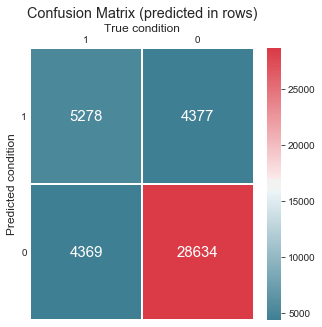

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dt_model.predict(x_test), y_test) # intentionally switched predictions with ground truth to have Predicted condition in rows

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='d', annot=True, annot_kws={'size': 15}, linewidths=.5)
ax.set_title('Confusion Matrix (predicted in rows)')
ax.set_ylim((0, 2))
ax.set_xlabel('True condition')
ax.set_ylabel('Predicted condition')
ax.invert_xaxis()
plt.yticks(rotation=0)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(length=0);

Wikipedia article about [presion and recall](https://en.wikipedia.org/wiki/Precision_and_recall) has a perfect matrix describing various metrics that we can obrain from confusion matrix.

<a href="https://en.wikipedia.org/wiki/Precision_and_recall"><img src="./imlp2_images/precision_recall.png" width="1000" /></a>

### Precision, Recall, F1-score

<center><img src="./imlp2_images/precision_recall_2.png" height="300"></center>

<img src="./imlp2_images/precision_recall_2.png"  style="float: right;" height="300">

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

$$ \text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Precision, recall, and f1-score are other commonly used metrics. Recall (also sensitivity and TPR) tells us how confident we can be that the model identified trully positive examples as positive. Precision tells us how often when the models does positive prediction it is trully positive example. There is always a tradeoff between precision and recall. Precision and recall are defined as follows:

*F1-score* is harmonic mean of precision and recall that offers one-number metric of model performance better than simple accuracy. Harmonic mean tends toward smaller values and is robust against high outliers thus F1-score highlights errors in predictions.

Precision, recall, and F1-score are best used with binary classification problem and they empasise performance on positive class and put less emphasis on negative class. That is intended in eg. medical applications where it more valuable to positively identify patients with illness rather than being certain about patiens not having and illness. *Average class accuracy* is good measure for cases when predictions for both classes are of the same importance.

*F1-score* is harmonic mean of precision and recall that offers one-number metric of model performance better than simple accuracy. Harmonic mean tends toward smaller values and is robust against high outliers thus F1-score highlights errors in predictions.

Precision, recall, and F1-score are best used with binary classification problem and they empasise performance on positive class and put less emphasis on negative class. That is intended in eg. medical applications where it more valuable to positively identify patients with illness rather than being certain about patiens not having and illness. *Average class accuracy* is good measure for cases when predictions for both classes are of the same importance.

### Average Class Accuracy

$$ \text{Average class accuracy} = \frac{1}{|\text{levels}(t)|} \sum_{l \in \text{levels}(t)} \text{recall}_l$$

In [34]:
# avg. class accuracy
from sklearn.metrics import recall_score
def avg_class_accuracy(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None)
    return np.sum(recalls) / recalls.shape[0]

print(f'Average class accuracy: {avg_class_accuracy(y_test, dt_model.predict(x_test)):.02}')

Average class accuracy: 0.71


### Rates

Confusion matrix describes performance of classification model in full and is used as a base for various metrics highlighting different qualities of the model. The most basic being *true positive rate (TPR)*, *true negative rate (TNR)*, *false positive rate (FPR)*, *false negative rate (FNR)*. They are defined as follows.

$$\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \text{ }\text{TNR} = \frac{\text{TN}}{\text{TN} + \text{FN}}$$

$$\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}, \text{ }\text{FNR} = \frac{\text{FN}}{\text{FN} + \text{TP}}$$

### Prediction Scores, Thresholds, and Curves

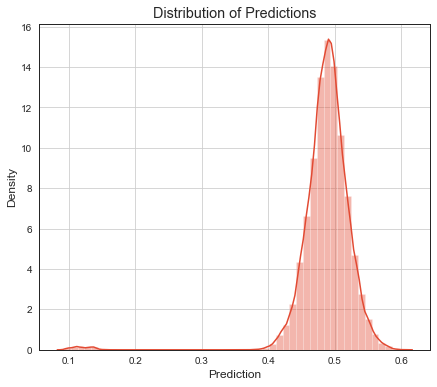

In [81]:
# distribution of predictions
y_score = ada_model.predict_proba(x_test)[:, 1]

fig, ax = plt.subplots(figsize=(7, 6))
sns.distplot(y_score, ax=ax)
ax.grid()
ax.set_title('Distribution of Predictions')
ax.set_xlabel('Prediction')
ax.set_ylabel('Density');

Many models do not output predicted class directly. They return prediction score that is thresholded to get predicted class as a output. Eg. logistic regression returns probability for positive class that is thresholded by $0.5$, decision tree returns probability of majority class, naive bayes returns maximum posterior probability.

Checking how much distribution of scores for different classes overlap, gives some additional insight into model performance. We can also evaluate metrics like precision and recall for different thresholds to visualize their tradeoff.

*ROC curve* shows TPR (aka. sensitivity or recall) against FPR (1 - specificity). As threshold increases, TPR decreases (because we classify less and less as 1) and TNR increases (because we classify more and more as 0). FPR is (1 - TNR).

*Precision vs Recall curve* helps us to find sweet spot (threshold) to optimize model predictions for class 1. We can see that moving decision threshold to around $0.495$ improves F1-score (on class 1) to $0.63$ while it was $0.59$ when using default threshold of $0.5$.

Max F1 on testing data (class 1) 0.64 with threshold 0.506
AUC on testing data (class 1) 0.87


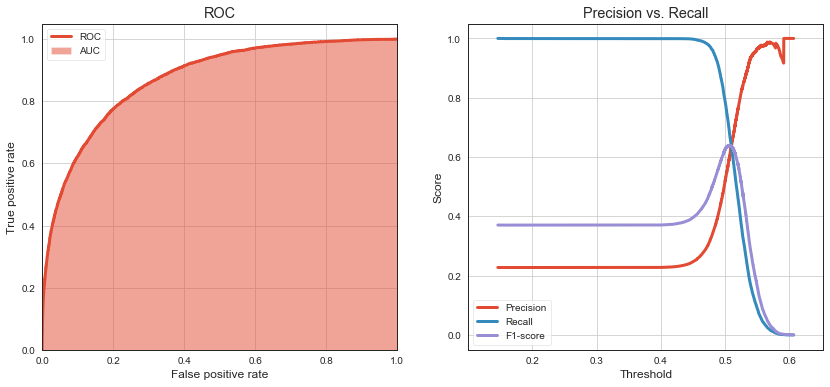

In [74]:
# roc, precision, recall, fscore based on thresholds
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

def plot_roc_curve(y_test, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    plt.grid()
    plt.plot(fpr, tpr, linewidth=3, label='ROC')
    plt.fill_between(fpr, 0, tpr, alpha=0.5, label='AUC')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title);
    plt.legend()
    return fpr, tpr, auc, thresholds

def plot_precision_recall_curve(y_test, y_score, title):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    thresholds_adjusted = np.append(thresholds, thresholds[-1])
    f_score = 2 * precision * recall / (precision + recall)

    plt.plot(thresholds_adjusted, precision, label='Precision', linewidth=3)
    plt.plot(thresholds_adjusted, recall, label='Recall', linewidth=3)
    plt.plot(thresholds_adjusted, f_score, label='F1-score', linewidth=3)
    plt.grid()
    ths_span = (thresholds[-1] - thresholds[0])*.1
    plt.xlim((thresholds[0] - ths_span, thresholds[-1] + ths_span))
    plt.title(title)
    plt.legend(loc='lower left')
    plt.xlabel('Threshold')
    plt.ylabel('Score');
    return precision, recall, f_score, thresholds

y_score = ada_model.predict_proba(x_test)[:, 1]
  
plt.figure(figsize=(14, 6))
plt.subplot(121)
fpr, tpr, auc, thresholds = plot_roc_curve(y_test, y_score, 'ROC')
plt.subplot(122)
precision, recall, f_score, thresholds = plot_precision_recall_curve(y_test, y_score, 'Precision vs. Recall')

print(f'Max F1 on testing data (class 1) {f_score.max():.2} with threshold {thresholds[np.argmax(f_score)]:.3}')
print(f'AUC on testing data (class 1) {auc:.2}')

### Prediction Errors

![error](./imlp2_images/bias_variance_2.png)

###  Bias and Variance

*Bias* - average prediction error, *Variance* - spread in predictions.

![bias](./imlp2_images/bull.png)

[Link](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

### Bias, Variance Tradeoff

![bv_tradeoff](./imlp2_images/bias_variance.png)

Single decision tree performance is good enough to get some insights into features driving predictions but is rearly optimal. Decision tree tend to grow very deep and do not generalize well on unseen data. They have low bias but high variance.

### Ways to Handle Bias, Variance Threshold

Ensemble Learning - Bagging, Boosting, Stacking

We can achieve better performace by using ensemble methods that help us trade variance for bias and vice versa. These methods usually train multiple weak (shallow) decision trees making a forrest out of them. Prediction of multiple models in ensemble is then usually a average of predictions from trees or a maximum. 

#### Bagging

In *bagging*, we train multiple weak decision trees on subsets of data bootstrapped from the dataset. We average their predictions. Avaraging of predictions from weak models with high variance and low bias reduces variance. Bagging can be parallelised. Random forrests train forrest of strong decision trees on bootstraps and also randomly choose subset of features to make trees look different.

![Bagging](./imlp2_images/bagging.png)

[Link](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

#### Boosting

In *boosting*, we train multiple weak decision trees again on subsets of data bootstrappedd from the dataset. In every step we weight data by the error previous models have on prediction to direct the next model to decide better about them. We combine weak models with high bias and low variance to reduce their bias using linear combination of their predictions. Coeficients of this linear combination describe how well weak model decided about the weighted dataset.

![Boosting](./imlp2_images/boosting.png)

[Link](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

#### Stacking

In *stacking*, we train multiple heterogenous (weak) models and then we train another model that uses predictions of multiple models as an input to get final prediction. For example, we train logistic regression, SVM, kNN classifiers and then we train neural net to get final prediction.

![Stacking](./imlp2_images/stacking.png)

[Link](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

We use adaptive boosting algorithm *AdaBoost* as and example of ensemble.

In [71]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [72]:
ada_model = Pipeline([('ct', ColumnTransformer(features)),
                      ('clf', AdaBoostClassifier(
                          base_estimator=DecisionTreeClassifier(max_depth=3, 
                                                                class_weight='balanced'), 
                          n_estimators=20))])
ada_model.fit(x_train, y_train);
print('Ada Boosting Classifier')
print(classification_report(y_test, ada_model.predict(x_test)))

Ada Boosting Classifier
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     33015
           1       0.52      0.79      0.63      9643

    accuracy                           0.79     42658
   macro avg       0.72      0.79      0.74     42658
weighted avg       0.83      0.79      0.80     42658



We check another single model in this case gradient boosted tree in xgboost package. This is state of the art model suitable for many classification and regression problems.

In [48]:
from xgboost import XGBClassifier

In [49]:
xgb_model = Pipeline([('ct', ColumnTransformer(features)),
                      ('clf', XGBClassifier(objective="binary:logistic"))])

xgb_model.fit(x_train, y_train);
print('Gradient Boosted Classifier')
print(classification_report(y_test, xgb_model.predict(x_test)))

Gradient Boosted Classifier
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33011
           1       0.75      0.50      0.60      9647

    accuracy                           0.85     42658
   macro avg       0.81      0.73      0.75     42658
weighted avg       0.84      0.85      0.84     42658



### Gain & Lift

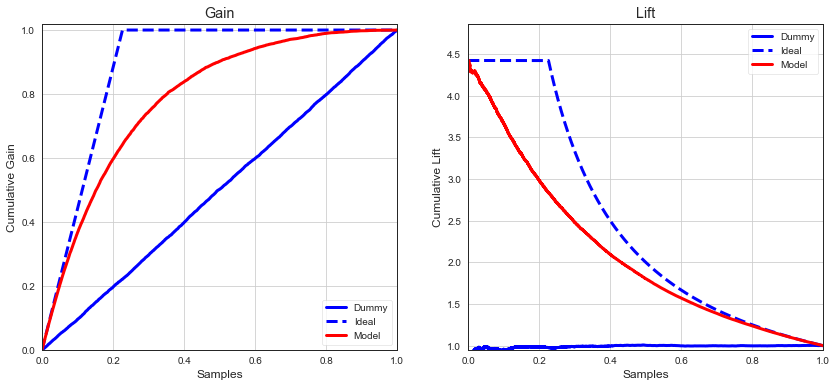

In [54]:
# lift and gain curves
from sklearn.dummy import DummyClassifier

def cumgain(y_score, y_test):
    n = y_test.shape[0]
    ticks = np.linspace(0., 1., num=n, endpoint=True)

    npos = y_test[y_test == 1].shape[0]
    s = y_test.values[np.argsort(y_score)[::-1]]
    cum_s = np.cumsum(s)
    cum_gain = cum_s / npos # cumulative gain
    return ticks, cum_gain

def cumlift(y_score, y_test):
    ticks, mgain = cumgain(y_score, y_test)
    n = y_test.shape[0]
    npos = y_test[y_test == 1].shape[0]

    ns = np.arange(1, n+1, step=1)
    lift = (mgain * npos / ns) / (npos / n) # cumulative lift
    return ticks, lift

def plot_gain_curve(model, x_test, y_test, title):
    dclf = DummyClassifier(strategy='stratified', random_state=0)
    dclf = sk.pipeline.Pipeline(model.steps[:-1] + [('clf', dclf)])
    dmodel = dclf.fit(x_train, y_train)

    ticks, m_gain = cumgain(model.predict_proba(x_test)[:,1], y_test)
    ticks, d_gain = cumgain(dmodel.predict_proba(x_test)[:,1], y_test)
    ticks, i_gain = cumgain(y_test, y_test)

    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Cumulative Gain')
    plt.xlim(0,1)
    plt.ylim(0,1.02)
    plt.grid(True)
    plt.plot(ticks, d_gain, '-', color='blue', linewidth=3, label='Dummy')
    plt.plot(ticks, i_gain, '--', color='blue', linewidth=3, label='Ideal')
    plt.plot(ticks, m_gain, '-', color='red', linewidth=3, label='Model')
    plt.legend(loc='lower right');
    return ticks, m_gain

def plot_lift_curve(model, x_test, y_test, title):
    dclf = DummyClassifier(strategy='stratified', random_state=0)
    dclf = sk.pipeline.Pipeline(model.steps[:-1] + [('clf', dclf)])
    dmodel = dclf.fit(x_train, y_train)

    ticks, m_lift = cumlift(model.predict_proba(x_test)[:,1], y_test)
    ticks, d_lift = cumlift(dmodel.predict_proba(x_test)[:,1], y_test)
    ticks, i_lift = cumlift(y_test, y_test)

    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Cumulative Lift')
    plt.xlim(0,1)
    plt.ylim(0.95, np.max(i_lift)*1.1)
    plt.grid(True)
    plt.plot(ticks, d_lift, '-', color='blue', linewidth=3, label='Dummy')
    plt.plot(ticks, i_lift, '--', color='blue', linewidth=3, label='Ideal')
    plt.plot(ticks, m_lift, '-', color='red', linewidth=3, label='Model')
    plt.legend(loc='top right');

plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_gain_curve(ada_model, x_test, y_test, 'Gain')
plt.subplot(122)
plot_lift_curve(ada_model, x_test, y_test, 'Lift')

### Gain

*Gain* measures how many of positive instanes in the overall test set are found in particular quartile.

$$ \text{Cumulative gain}(x) = \frac{\text{# positive instances up to ranked instance}\, x}{\text{# positive test instances}}$$

### Lift

*Lift* measures how much a model A is better than some benchmark model B.

$$ \text{Cumulative lift}(x) = \frac{\text{% of positive instances up to ranked instance}\, x}{\text{% of positive test instances}}$$

Sometimes we want to act on predictions of class 1 only eg. to filter spam, report fraud, customers responding to campaign. Lift and gain metrics describes how well we would do if we ranked class 1 predictions by prediction score in descending order. In well performing model, we expect majority of true positive instances to be close to the top of ranking. Gain and lift measures to what extend this assumptions is correct.

Lift tells us how much higher the actual percentage of positive instances identified by model A is than the rate expected by model B.
 
Eg. in campaign optimization settings, cumulative gain tells us how many users we have to contact to target $X%$ of users who are most likely to respons.

It's sometimes handy to see gain and lift charts by decile for better comprehension.

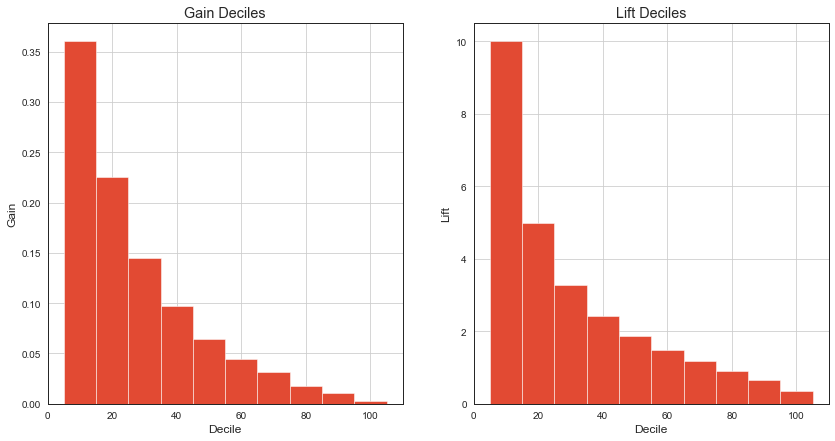

In [77]:
# gain and lift by deciles

def declift(y_score, y_test):
    deciles = np.linspace(10, 100, 10)
    ticks, mgain = gain(y_score, y_test)
    decgain = np.percentile(mgain, deciles)[::-1]
    n = y_test.shape[0]
    npos = y_test[y_test == 1].shape[0]

    ns = np.percentile(np.arange(1, n+1, step=1), deciles)
    lift = (decgain * npos / ns) / (npos / n) # decile lift
    return lift

gains = np.diff(np.percentile(gain(y_score, y_test)[1], deciles), prepend=0)
lifts = declift(y_score, y_test)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('Gain Deciles')
plt.xlabel('Decile')
plt.ylabel('Gain')
plt.grid(True)
plt.bar(deciles, gains, 10);

plt.subplot(122)
plt.title('Lift Deciles')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.grid(True)
# plt.ylim(0., lifts.max()*1.1)
plt.bar(deciles, lifts, 10);

### Learning Curve

Learning curves show progress in learning over time in terms of adding more samples to learn from. It can be used to:

1. Diagnose underfit, overfit, or well-fit model.
1. Tell if obtaining more data helps.
1. Tell if using more complex model or longer training times helps.

*Underfitting* refers to a model that cannot learn the training dataset.

1. Model not complex enough - we can see it by decreasing training curve or flat training curve on lower scores. Model can learn smaller datasets well, but as we are adding more data, model starts having difficulties to classify correctly.
1. More data needed - if training curve is increasing toward its end, it signals obraining more training data or giving model more time to learn would help. 

*Overfitting* refers to a model that learned the training dataset too well including noise or randomness.

Training curve increases with experience and validation curve increases and than starts decreasing again. The inflection point is when we could stop training.

*Good fit* is identified by a training and validation curves that increase, become flat, and the generalization gap between training and validation curves is narrow.

*Unrepresentative dataset* means that the training dataset does not provide sufficient information to learn the problem. this is signaled by training curve converging to lower scores.

Some more details can be found [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

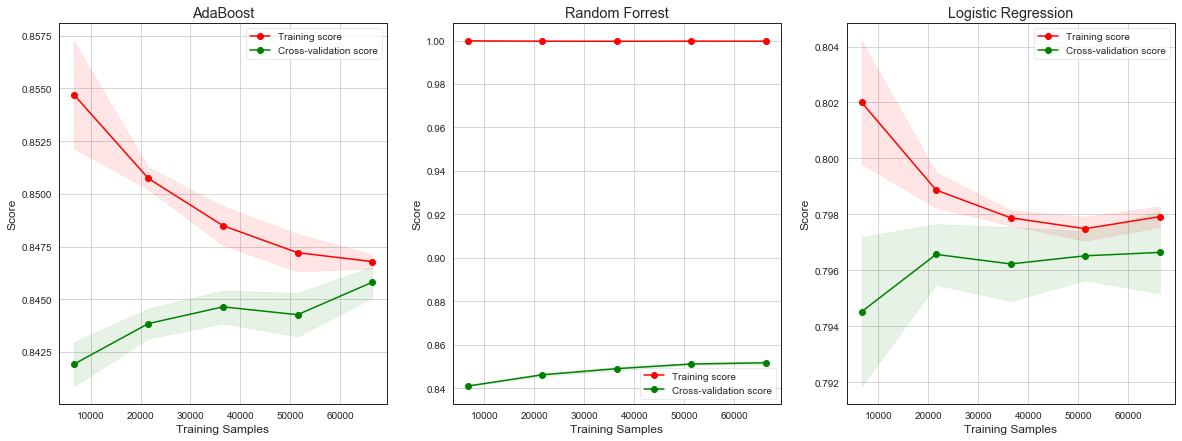

In [24]:
# learning curves
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, x_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.title(title)
    plt.xlabel('Training Samples')
    plt.ylabel('Score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best");
    
plt.figure(figsize=(20, 7))
plt.subplot(131)
plot_learning_curve(ada_model, x_train, y_train, 'AdaBoost')
plt.subplot(132)
plot_learning_curve(rf_model, x_train, y_train, 'Random Forrest')
plt.subplot(133)
plot_learning_curve(logit_model, x_train, y_train, 'Logistic Regression')

### Cross-validation

Hyper-parameters tune machine learning algorithm, are given upfront and are not learned by it. Examples could be maximum number of iterations in logistic regression, number of estimators in random forrest, max depth of a weak learner in XgBoost.

It is recommended to search hyper-parameter space for the set of hyper-parameters with the best cross validation score.

Hyper-parameter search needs to evaluate many different versions of ML algorithm on the same dataset, we need to ensure some fairness in learning and evaluation.

*Cross validation* helps us to prevent overfitting of a model at hand by presenting it with data it hasn't seen in training phase. It is similar to hold-out test set concept but generalize it when we need multiple such splits to evaluate perfomance of multiple models. It also prevents getting *lucky split* which put more difficult instances to the training data and easy instances to testing data. In $k$-fold cross validation, we split data into $k$ folds (partitions), and we do $k$ separate training and evaluation steps using $k-1$ folds for training and the $k$th fold for evaluation in every step.

$4$-fold cross validation
![4-fold cross validation](./imlp2_images/cross_validation.png)

### Hyper-parameter Tuning

Following are common techniques used for hyper-parameter search.

1. **Grid search** - exhaustive, goes through all possible combinations of given hyper-parameters and their values.
1. **Randomized search** - samples given number of possible combinations of given hyper-parameters and their distributions of values.
1. **Bayesian optimization** - [Link]()

Some more details are available [here](https://scikit-learn.org/stable/modules/grid_search.html) and [here](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).

We try to find the best set of parameters for our *RainTomorrow* weather problem.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

train, test = train_test_split(df, test_size=.25)

#### Stacking More Models and Grid Search

In [ ]:
pipeline = [('ct', ColumnTransformer(features)),
            ('sca', StandardScaler()), 
            ('clf', VotingClassifier([('lr', LogisticRegression(solver='lbfgs')),
                                      ('rd', RandomForestClassifier(class_weight='balanced')),
                                      ('xgb', XGBClassifier())], voting='soft'))]

In [ ]:
params = {'clf__lr__max_iter': [2000, 3000],
          'clf__lr__class_weight': ['balanced', {0:1, 1:10}],
          'clf__rd__n_estimators': [5, 30, 50],
          'clf__rd__max_depth': [5, 10],
          'clf__xgb__n_estimators': [20, 30, 100],
          'clf__xgb__max_depth': [2, 4],
          'clf__voting': ['soft', 'hard']}

In [ ]:
x_train = train.drop('RainTomorrow', axis=1)
y_train = train['RainTomorrow']

x_test = test.drop('RainTomorrow', axis=1)
y_test = test['RainTomorrow']

In [6]:
grid_model = GridSearchCV(Pipeline(pipeline), 
                          param_grid=params, 
                          n_jobs=-1, cv=3, 
                          scoring='f1', iid=False, verbose=2)
grid_model.fit(x_train, y_train);
print(f'\nThe best cross-validation f1-score: {grid_model.best_score_}')
print(f'\nThe best parameters: {grid_model.best_params_}')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 117.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 205.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 274.0min finished



The best cross-validation f1-score: 0.6545548221233476

The best parameters: {'clf__lr__class_weight': 'balanced', 'clf__lr__max_iter': 2000, 'clf__rd__max_depth': 10, 'clf__rd__n_estimators': 50, 'clf__voting': 'soft', 'clf__xgb__max_depth': 4, 'clf__xgb__n_estimators': 100}


In [36]:
print('\nClassifition report on testing dataset\n')
print(classification_report(y_test, grid_model.predict(x_test)))


Classifition report on testing dataset

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     33066
           1       0.62      0.71      0.66      9592

    accuracy                           0.84     42658
   macro avg       0.77      0.79      0.78     42658
weighted avg       0.85      0.84      0.84     42658



In [ ]:
params_simple = {'clf__lr__C': [0.5],
          'clf__lr__max_iter': [500, 1000],
          'clf__lr__class_weight': ['balanced'],
          'clf__rd__n_estimators': [5],
          'clf__rd__max_depth': [5],
          'clf__xgb__n_estimators': [5],
          'clf__xgb__max_depth': [2],
          'clf__voting': ['soft']}

<a id="explain"></a>
## Insights & Explanations

1. A bank needs to be able to explain why the loan wasn’t granted if the decision process was automatic. This is direct consequence of implementing GDPR in EU.

1. In October 2018 world headlines reported about [Amazon AI recruiting tool](https://www.theguardian.com/technology/2018/oct/10/amazon-hiring-ai-gender-bias-recruiting-engine) that favored men. Amazon’s model was trained on biased data that were skewed towards male candidates. It has built rules that penalized résumés that included the word “women’s”.

[Link](https://appsilon.com/please-explain-black-box).

Having insight into internal configuration of learned model helps answering questions about trust and getting actionable information for stakeholders. Irrelevant or partially relevant features can negatively impact model perfomance. We can try to:

1. Explain model as a whole using different kinds of feature importances.
2. Single predictions made by a model using eg. Lime or Shapley values.

### Feature Importance

Feature importance describes aggregated per-feature information.

1. Univariate statistical tests selects features with the highest variance in the data.
1. We can use linear model with L1 regularization like logistic regression or SVM for classification or Lasso for regression problems for selecting the best features for more complex model.
1. We can use learned model to output the most important features to tell us about its internal working.

### Univariate Selection

Using Anova f-score of feature values and target label for univariate feature selection.

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [56]:
m = Pipeline([('ct', ColumnTransformer(features)),
              ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
              ('clf', AdaBoostClassifier())])

m.fit(x_train, y_train)
fscores = pd.DataFrame({'feature': fs, 'score': m.named_steps['feature_selection'].scores_})
print(fscores.nlargest(10, 'score'))

          feature         score
3     Humidity3pm  23656.062117
23       Sunshine  11712.944411
28      RainToday  10283.188282
1        Cloud3pm   9502.777522
2     Humidity9am   7007.758958
0        Cloud9am   6539.568606
21       Rainfall   6005.641114
4     Pressure9am   5811.952766
20  WindGustSpeed   5318.624426
5     Pressure3pm   4856.702614


### Select Features from Simple Model

Using simple logistic regression model with L1 regularization to filter features before feeding them to the more complex boosting model.

In [57]:
from sklearn.feature_selection import SelectFromModel

In [57]:
m = Pipeline([('ct', ColumnTransformer(features)),
              ('feature_selection', SelectFromModel
                (LogisticRegression(penalty='l1', class_weight='balanced'), 
                 threshold='median')),
              ('clf', AdaBoostClassifier())])
m.fit(x_train, y_train)
print(classification_report(y_test, m.predict(x_test)))

Classifition report on testing dataset

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     33131
           1       0.59      0.22      0.32      9527

    accuracy                           0.79     42658
   macro avg       0.70      0.59      0.60     42658
weighted avg       0.76      0.79      0.75     42658



In [58]:
m.steps.pop(len(m.steps) - 1)
t = m.transform(x_test)
print(f'Using {t.shape[1]} features for the final model')

Using 117 features for the final model


### Feature Importance

We can visualize feature importance from a trained classifier. 

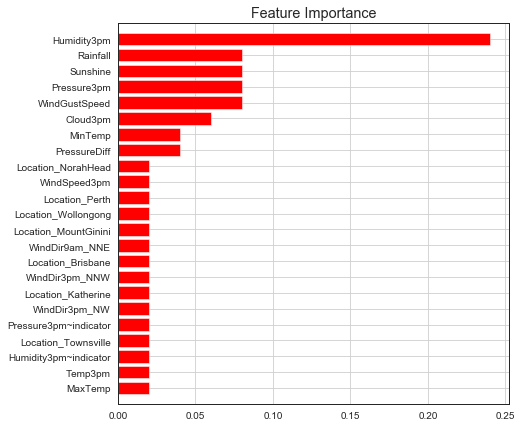

In [59]:
# Feature importance
ada_model = AdaBoostClassifier()
ada_model.fit(x_train_trans, y_train)

# print(classification_report(y_test, ada_model.predict(x_test_trans)))

def plot_feature_importances(feature_names, importances, importances_for_std=None, threshold=None, figsize=(7, 7), title='Feature Importance'):
    features = np.array(feature_names)
    importances = pd.Series(importances).sort_values(ascending=True)
    importances = importances[abs(importances) >= threshold] if threshold is not None else importances 
    indices = importances.index.values

    std = np.std(importances_for_std[:, indices], axis=0) if importances_for_std is not None else None

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color="r", align="center", xerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.ylim([-1, len(indices)])
    plt.grid(True)
    
plot_feature_importances(fs, ada_model.feature_importances_, threshold=0.01)

### Model as a Blackbox, Explain Single Prediction

Getting feature importance is not descriptive enough in many cases. We need to explain individual model predictions. Scenarios that follow are common use-cases of single prediction explanations.

#### Lime - Local Interpretable Model

![lime](./imlp2_images/lime.png)

[Lime](https://github.com/marcotcr/lime) tries to explain prediction for given data sample by fitting simple and directly interpretable model to sample of training data weighted by their distance to given data sample.

The black-box model’s complex decision function $f$ (unknown to LIME) is represented by the blue/pink background, which cannot be approximated well by a linear model. The bold red cross is the instance being explained. LIME samples instances, gets predictions using f, and weighs them by the proximity to the instance being explained (represented here by size). The dashed line is the learned explanation that is locally (but not globally) faithful ([link](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf)).


In [60]:
from sklearn.preprocessing import MinMaxScaler
from lime.lime_tabular import LimeTabularExplainer

m = Pipeline([('ct', ColumnTransformer(features)),
              ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
             ])

xtr = m.fit_transform(x_train, y_train)
xte = m.transform(x_test)
scores = m.named_steps['feature_selection'].scores_
feature_names = np.array(fs)[np.flip(np.argsort(scores))[:10]]

m = AdaBoostClassifier()
m.fit(xtr, y_train);

lime_explainer = LimeTabularExplainer(xtr, feature_names=feature_names, class_names=['No', 'Yes'])

In [61]:
# examplaining single prediction
s = np.random.randint(0, xte.shape[0])
sample = xte[s]
exp = lime_explainer.explain_instance(sample, m.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)
print(f'True label: {y_test.iloc[s]}')

True label: 0


Single explanations have a big disadvantage that we can hardly draw any conclusions about what drives groups of model predictions. Some combination of using feature importance and single explanations would be handy as many state of the art models are virtually black boxes.

Some basic approaches could be:

1. Try to turn features on and off and measure their impact on performance metrics.
2. Try to change feature values of some data points to see what drives model to alter prediction.

#### Shapley Values (SHapley Additive exPlanations)

[Shapley values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) try to distribute contribution of features to modeled outcome fairly. It averages individual feature $i$ contributions by adding it to all possible subsets of features. The contribution of adding feature $i$ to some subset is also weighted by how many feature subsets is represents.

Feature $i$ Shapley value $\phi_i$ for model $f$ and instance $x$ is

$$\phi_i(f, x) = \sum_{z' \subseteq x'}\frac{|z'|!(M - |z'| - 1)!}{M!} \left[ f_x(z') - f_x(z' \backslash i) \right]$$

where $z'$ ($x'$) is simplified version of instance $z$ ($x$) where some features are "zeroed", $M$ is the size of the full feature set. The bit at the end is just “how much bigger is the contribution when we add feature $i$ to this particular subset $z'$”.

In [67]:
from xgboost import XGBClassifier
import shap

xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train_trans, y_train)

shap_explainer = shap.TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(x_test_trans, y_test)

Individual prediction explanation. Red features push prediction higher, blue features push prediction lower.

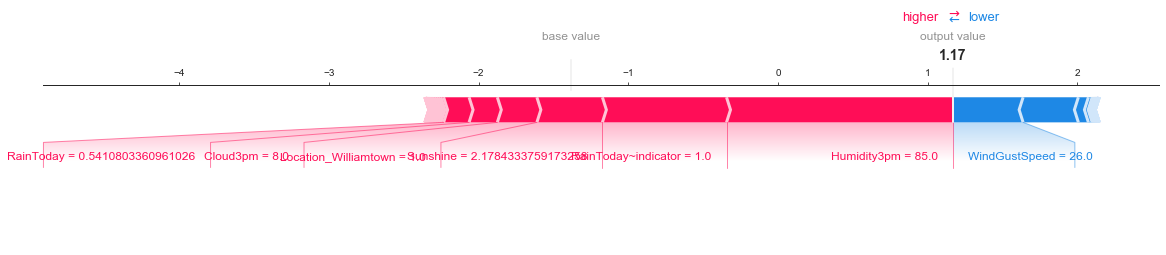

In [68]:
shap.force_plot(shap_explainer.expected_value, shap_values[1,:], x_test_trans[1,:], feature_names=fs, matplotlib=True)

Feature importance plot giving us overview of Shapley value distributions and signs of the contribution.

#### Aggregated Shapley Values

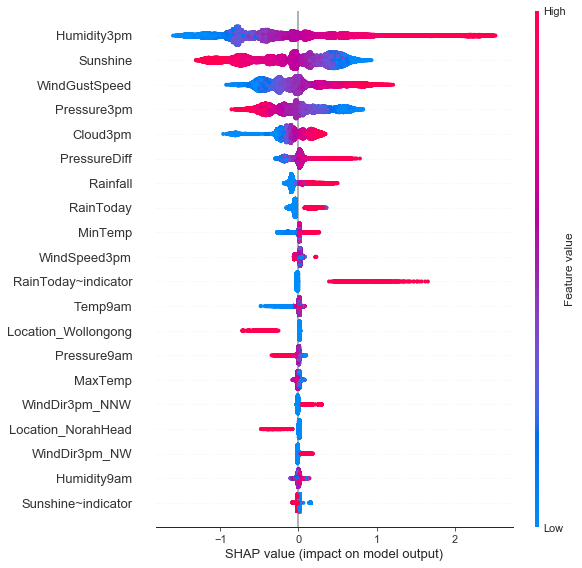

In [73]:
shap.summary_plot(shap_values, x_test_trans, fs, class_names=['No', 'Yes'])

1. [NIPS Paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions)
1. [Simple Explanation](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d)
1. [Shapley Implementation](https://github.com/slundberg/shap)

<a id="tech"></a>
## What Technology to Use

Technology stack in ML is much less matured compared to eg. software engineering. Best practices are undeveloped, it is very important to choose technology stack well.

![ml workflow](./imlp2_images/ml_workflow.jpeg)
[Link](https://medium.com/memory-leak/introducing-redpoints-ml-workflow-landscape-312ca3c91b2f)

### Impact of Data Size and Model Complexity

Take this with reserve, it's just an example how to think about what basic technology will be needed.

| Dataset Size | Model Complexity | Tool              | Hardware |
| ------------ | ---------------- | ----------------- | -------- |
| < 5GB        | Linear, Ensemble | Scikit-learn      | CPU      |
| < 5GB        | DNN              | TensorFlow        | CPU      |
| < 100GB      | Linear           | eg. Vowpal Wabbit | CPU      |
| < 100GB      | DNN              | TensorFlow        | CPU(s)   |
| < 100GB      | CNN, RNN         | TensorFlow        | GPU      |
| >= 100GB     | DNN, CNN, RNN    | TensorFlow        | GPU(s)   |

DNN stands for deep fully connected network, CNN for convolutional neural network, and RNN for recurrent neural network. TensorFlow can be replaced with any other similar tool like PyTorch, 

<a id="team"></a>
## Sharing Knowledge in Team

Machine learning is iterative process, there are new ideas to try, new models to evaluate, new features to add, more data to play with. Sometimes datasets need to be revisited with fresh knowledge to crack modeling problem. Every analysis of data puts piece of puzzle in place. Knowledge has to be documented to be able to share it among data scientists in a form that is acceptible to them.

We made a good experience with following setup

1. We version our scratchpad and unfinished notebooks in git repository just to backup them at the one place.
1. When we finalize some data analysis or modeling, we create a knowledge post using Airbnb's [Knowledge Repository](https://github.com/airbnb/knowledge-repo) tool.
1. All knowledge posts share the same structure
    1. tl;dr summary
    1. Results
    1. Data used, limitations
    1. Analysis itself with comments
    1. Appendix (mostly SQL code used)
1. All notebooks have to be self-contained with all SQL code needed to retrieve data. Anyone that needs to reiterate on the problem can run, replicate, and verify complete notebook.
1. Data analysis and modeling is usually not so satisfactory work on day or week span, it gets satisfacory over time though. Creating nicely formatted notebooks now and then largely improves satisfaction from daily work.

Example of knowledge repository.

![Knowledge Repository](https://user-images.githubusercontent.com/124910/37555895-d6ad133a-2a42-11e8-9bb5-1b7ee8d60ef9.png)

<a id="deploy"></a>
## Deploy & Monitor

After we deploy model into production, we have to monitor its perfomance. Models are built with some assumptions over distributions of input features and patterns learned from input features. Data changes over time causing *concept drift* and making models to lose performance, going stale, and requiring retraining (at least).

To monitor performance of the model we have to be notified about something has changed.

1. The perfomance of the model changed.
1. The distribution of the outputs of the model changed.
1. The distribution of individual features on model output changed.
1. Compare perfomance of the model on some business metric using control group.

To monitor the change in the performance metrics of the model would require to acquire true label soon after prediction of the model is made which is usually hard.

If we act on several decicels of "best" predictions only, we can check ratio of how many samples are above some threshold versus how many sample is below the threshold. This ratio should be stable from test set to production. If it changes, it signals a change in distribution of model outputs.

### Stability Index

We can use *stability index* to measure changes in distribution of model outputs.

$$ \text{Stability index} = \sum_{l\in\text{levels}(t)} \left( \left(\frac{|A_{t=l}|}{|A|} - \frac{|B_{t=l}|}{|B|}\right) \times \log_e  \left(\frac{|A_{t=l}|}{|A|} / \frac{|B_{t=l}|}{|B|}\right)\right) $$

Distributions are silimar if stability index is less than 0.1, has some change for stability index <= 0.25 and stability index > 0.25 suggests that there has been significant change.

<a id="production"></a>
## Keep Training and Production Environments Same

We try to keep following rules in mind when deciding about deployment.

1. Training and production environment should be as similar as possible.
2. There should be as less transformations applied to data prior they enter our ML pipeline as possible. Working with meaningful and yet unscaled values simplifies model debuging a lot. Mind that there are no tools to debug misbehaving models.

### ModelRunner Abstraction

Machine learning steps like splitting data for cross validation, training, evaluation, prediction are always the same. Many business applications are using the same data and the same transformations of the data again and again. It is much more practical to have some catalog of higher level features we can use to declaratively configure our solution.

1. *ModelRunner* is template class that implements machine learning workflow for classification or regression.
2. ModelRunner is configured with *DataSource* to be able to load dataset.
3. *DataSource* calls instance of *Extractor* that specifies how to query for data eg. querying underlying database via *Connection* and eg.  SQL.
4. ModelRunner also receives list of *Feature*s. Every Feature maps some columns from training (testing) data frame to list of *Transformers*. This allows us to declaratively reuse commonly used features rather than coding them again and again in Pipeline.
5. ModelRunner evaluates its estimator (specified as Pipeline) using list of *Evaluators* where every Evaluator stands for one metric eg. AUC for classification or MSE for regression.
6. ModelRunner can pickle and unpickle itself to allow us to move trained models from one place to another.
7. We can unit-test every component (Extractor instances, custom sklearn transformers, Evaluators and ModelRunner instances (trained models) in isolation and deploy their code using standard CI/CD techniques. Once the code is deployed in production, we only move pickled instance of ModelRunner and unpickle it.
8. Extractor abstraction allows us to use one trained instance of ModelRunner with different source of data.
    1. We can prepare data via SQL query to Hive database in training phase using Extractor that uses database connection.
    1. We can get predictions for batches of data using Extractor that reads incoming RabbitMQ messages in production.

<img src="./imlp2_images/ModelRunner1.png" width="800"/>

## Resources

1. John D. Kelleher et al., [Fundamentals of Machine Learning for Predicitve Data Analytics](https://www.amazon.com/Fundamentals-Machine-Learning-Predictive-Analytics/dp/0262029448/ref=sr_1_1?keywords=machine+learning+for+predictive+data+analytics&qid=1569507170&sr=8-1)
2. Sebastian Raschka, [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka-ebook/dp/B00YSILNL0)
3. Ian Goodfellow et al., [Deep Learning](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=sr_1_1?crid=1H65RO9KWHYRL&keywords=goodfellow+deep+learning&qid=1572383007&sprefix=goodfellow+deep%2Caps%2C258&sr=8-1)
4. [A Data Science Framework to chieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)